# Self Organizing Map Analysis Prototype

## Overview
This notebook documents a simple prototype workflow to use Self Organizing Map (SOM) analysis as a clustering approach for large-scale environments associated with (nominally) MCSs. As you will see, they are nominally MCSs because I am using a very simple detection and tracking approach that may not be adequate for discriminating MCSs. 

## Import Libraries
There are just a couple of libraries that are being used. 
- pathlib provides simple, concice methods for dealing with the file system; this is optional since simple strings could also be used.
- numpy is the basic numerical package that does array math efficiently
- pandas is an general purpose statistical analysis package; it probably is not needed here, but it is used internally in dt (see below)
- xarray is the multi-dimensional version of pandas; provides multidimensional arrays wtih named coordiates along with analysis methods
- minisom is the package used for the SOM analysis; there are several, and it is not clear whether one is better than the others
  + [https://github.com/JustGlowing/minisom]
- detect_and_track is a LOCAL module that I developed for very simple feature detection and tracking using computer vision methods
- matplotlib and cartopy provide visualization tools

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

from minisom import MiniSom

import detect_and_track as dt

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

## Data

The data comes from an ne120 global F-case, which I think is using an AMIP compset. The years available appear to be 1986 to 2004 or so, and only have April and May available. The files have been regridded to an approximately 0.25° lat-lon grid. I extracted files that only cover 20N - 55N, 250E - 290E. I have `PRECT`, `Q` at the 28th model level, and `V` at the 28th model level. The data are 3-hourly. I made no attempt to adjust the time coordinate using `time_bnds`.

I moved these small files to my Mac (on an external drive). I just load the May data for each variable using a glob; xarray prefers to put them into a (time, lat, lon) array since the times can be ordered. For the analysis here, the ordering of the data is irrelevant, so I did not spend any effort thinking about any details of arranging time.  

In [2]:
# data
fils = sorted(list(Path("/Volumes/Samsung_T5/mcs_tmp").glob("MAY*.nc")))
ds = xr.open_mfdataset(fils, combine='nested')
ds

<xarray.Dataset>
Dimensions:  (lat: 149, lev: 1, lon: 129, time: 4712)
Coordinates:
  * time     (time) object 1986-05-01 00:00:00 ... 2004-05-31 21:00:00
  * lat      (lat) float64 20.07 20.3 20.53 20.77 ... 54.09 54.33 54.56 54.8
  * lon      (lon) float64 250.0 250.3 250.6 250.9 ... 289.1 289.4 289.7 290.0
Dimensions without coordinates: lev
Data variables:
    Q        (time, lev, lat, lon) float32 dask.array<chunksize=(4712, 1, 149, 129), meta=np.ndarray>
    date     (time) float64 dask.array<chunksize=(4712,), meta=np.ndarray>
    V        (time, lev, lat, lon) float32 dask.array<chunksize=(4712, 1, 149, 129), meta=np.ndarray>
    PRECT    (time, lat, lon) float32 dask.array<chunksize=(4712, 149, 129), meta=np.ndarray>
Attributes:
    history:  Fri Dec 18 17:29:28 2020: ncks -d lat,20.,55. -d lon,250.,290. ...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

In [3]:
lat = ds['lat']
lon = ds['lon']
pdata = ds['PRECT'].load()  # load() forces the data into memory in case it is a dask array

## Detection and tracking

To approximate other methods of detecting and tracking MCSs, I used the precipitation rate and applied the same method I used to detect and track extreme tropical precipitation events. First, find the 95th percentile of `PRECT` at each grid point; since only the May data is loaded, I did not worry about trends or seasons. The 95th percentile was chosen arbitrarily with the goal of identifying only some pretty extreme events at each location.

Since there's just one quantile (but it varies in space), construct a mask based on `PRECT >= P95`. The `np.where()` function works for this perfectly, including broadcasting from the 2D variable the 3D shape of the precipitation array.



In [4]:
# get the quantiles of prect at each grid point
quants = np.nanquantile(ds['PRECT'].values, .95, axis=0)
quants_xr = xr.DataArray(quants, dims=["lat","lon"], coords={"lat":ds['lat'], "lon":ds['lon']})

In [5]:
mask = np.where(pdata >= quants, 1, 0)
mask.shape
# this works well enough. We get a space-dependent mask based on the local quantile value.

(4712, 149, 129)

In [6]:
# load the environment data, extract just the times associated with initiation
v_fils = sorted( list( Path("/Volumes/Samsung_T5/mcs_tmp").glob("MAY*.V.*") ) )
v_ds = xr.open_mfdataset(v_fils, combine='nested')
v = v_ds['V'].load()

q_fils = sorted( list( Path("/Volumes/Samsung_T5/mcs_tmp").glob("MAY*.Q.*") ) )
q_ds = xr.open_mfdataset(q_fils, combine='nested')
q = q_ds["Q"].load()


### Some initial figures

The first of three preliminary figures shows the map of the 95th percentile pattern. This is in m/s, just because I didn't multiply.

The second figure shows an arbitrary snapshot of `PRECT` in color with the contour showing the mask at the same time. This is to check if the mask is capturing the major precipitation features. Based on looking at a few of these snapshots, it seems like the 95th percentile is probably overly permissive, but the big events are definitely captured. The third figure shows another example, this time transforming to mm/day to get a sense for how big these precip rates are.

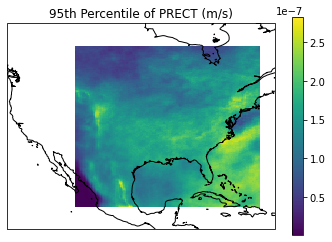

In [7]:
# FIGURE SHOWS P95 (no units conversion)

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
lons, lats = np.meshgrid(lon, lat)
img = ax.pcolormesh(lons, lats, quants, transform=ccrs.PlateCarree())

ax.set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())

# Optoinally add state boundaries
# ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='k')

ax.coastlines()
ax.set_title("95th Percentile of PRECT (m/s)")
fig.colorbar(img)

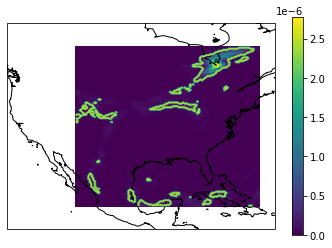

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
lons, lats = np.meshgrid(lon, lat)
img = ax.pcolormesh(lons, lats, pdata[-255, :, :], transform=ccrs.PlateCarree())
ming = plt.contour(lons, lats, mask[-255, :, :])
ax.set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(img)


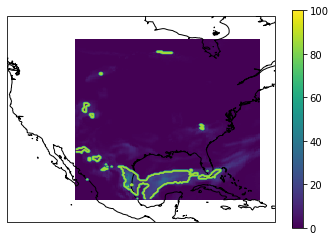

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
lons, lats = np.meshgrid(lon, lat)
img = ax.pcolormesh(lons, lats, pdata[1462, :, :]*86400.*1000., transform=ccrs.PlateCarree(), vmin=0, vmax=100)
ming = plt.contour(lons, lats, mask[1462, :, :])
ax.set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(img)



### Tracking

The next step is to identify individual events and combine in time to track events. The algorithm is extremely simple. Essentially the same masking as we just looked at is applied to detect events, and labels are applied. The label of an event persists in time if the threshold is matched in the next time in an overlapping (or directly adjacent) grid cell. In testing this approach, it seems relatively successful, but tends to produce long-lasting events when using daily data; I haven't explored 3-hourly or high-resolution enough to have a good sense if that holds.

The code is contained in my module `detect_and_track`, and the function `pr_labeler` is a controller that holds the logic to figure out how to set up the options. In my previous application, the `quants` paramter was set to a constant value, but here it varies in space. This works with no modification to the code. 

THe function `summarize_events` tries to report on some aspects of the labeled events. Here we see that there are on average 10.77 events per time slice, their average duration is 2.36 time slices (so a little over 6 hours), with a size of 10.57 grid cells and an average maximum size (over the duration) of 20 grid cells. This size based on grid cells is crude, but gives a sense for the size of events.

The function `get_duration_and_size` is produdces a pandas DataFrame with each event as a row and label, duration, size (per time slice), average size and maximum size as columns. This is why we imported pandas, to allow us to investigate this table.

In order to identify the "initiation" time of the events, I wrote a new function called `initiation_mask`. It works on the DataArray of labels, and produces a new DataArray of the same size. The values in the new mask are set to zero unless it is the first time of an event, in which case the value is one at the location of initiation.

We use this mask to isolate the initiation time in our environmental parameters, v and q. This reduces the data to be analyzed with the SOM to a small fraction of the original data. We are only looking at the large scale environment at the same time that precipitation events are flagged as forming.

In [10]:
%%time
m0_labels, m0_nfeatures = dt.pr_labeler(
        pdata, quants, track=True, latitude=None, connect=None
    )

CPU times: user 949 ms, sys: 143 ms, total: 1.09 s
Wall time: 1.09 s


In [11]:
dt.summarize_events(m0_labels, "amip_may", "simpleblobs")

amip_may simpleblobs: [N_events] = 10.77 ± 4.26, Ntot: 21527.00, [D] = 2.36 ± 5.60, [S] = 10.57 ± 39.89, [Smx] = 20.10 ± 103.57


In [51]:
event_df = dt.get_duration_and_size(m0_labels, rettype='df')

,duration,size,AvgSiz,MaxSiz
2,11,"[189, 133, 125, 111, 69, 50, 73, 66, 30, 10, 20]",79.636364,189
3,3,"[2, 3, 3]",2.666667,3
7,19,"[324, 293, 196, 112, 61, 47, 140, 233, 202, 11...",118.526316,324
9,8,"[85, 85, 119, 117, 94, 63, 40, 10]",76.625000,119
10,5,"[4, 13, 10, 7, 1]",7.000000,13
...,...,...,...,...
21468,4,"[85, 155, 107, 27]",93.500000,155
21470,6,"[12, 28, 44, 55, 43, 24]",34.333333,55
21486,5,"[6, 23, 52, 81, 56]",43.600000,81
21487,4,"[5, 40, 66, 96]",51.750000,96


In [12]:

def get_initial_tindex(labels, ev):
    if isinstance(labels, np.ndarray):
        labv = labels
    else:
        labv = labels.values  # converts to numpy array
    for t in range(labv.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if ev in present_events:
            return t
    return None


def initiation_mask(labels):
    """Only keep event labels in the first time slice they appear."""
    list_of_known_events = []
    output = labels.copy()
    ntim = labels.shape[0]  # assume time is first dimension
    for i in range(ntim):
        tmp = labels[i,:,:]
        current_events = np.unique(tmp)
        current_events = current_events[current_events != 0]
        for ce in current_events:
            if ce not in list_of_known_events:
                tmp = np.where(tmp==ce, 1, ce)  # keep points that belong to new event
                list_of_known_events.append(ce)
        output[i,:,:] = np.where(tmp==1, output[i,:,:], 0)  # mask to 0 unless a new event
    return output
    

In [13]:
# here are events labeled only during their initial time
mcs_initial = initiation_mask(m0_labels)
mcs_initial_selection = m0_labels[np.where(mcs_initial.max(dim=('lat', 'lon'))>0, True, False), :, :] # this is how we need to select vars

In [14]:
mcs_initial_da = xr.DataArray(mcs_initial, dims=pdata.dims, coords=pdata.coords)
mcs_initial_da

<xarray.DataArray (time: 4712, lat: 149, lon: 129)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int32)
Coordinates:
  * time     (time) object 1986-05-01 00:00:00 ... 2004-05-31 21:00:00
  * lat      (lat) float64 20.07 20.3 20.53 20.77 ... 54.09 54.33 54.56 54.8
  * lon      (lon) float64 250.0 250.3 250.6 250.9 ... 289.1 289.4 289.7 290.0

## SOM analysis

Following Song et al. (2019; DOI 10.1175/JCLI-D-18-0839.1), we _standarize_ the environmental data. We remove the mean and divide by the standard deviation. This is to put v and q (or whatever) onto equal footing when they are combined into the same statistical analysis. 

### first try: fail
In my first attempt, I tried to make q and v 1-dimensional vectors and concatenate them into one array. In this approach, I was essentially treating each grid cell (time, lat, lon) as an "observation" (in ML terms) and q and v provide the 2-element "feature vector" at each point. 

I set the some to have a shape of (1,4) following Song et al. and used standard hyperparameters from the `minisom` examples. 

This approach fails. All the data seems to separate into two nodes. This approach does not make sense because it would really just be working on individual values of q' and v' with no spatial information. The reconstruction to physical space does not seem obvious, and would not necessarily have anything to do with the large-scale environments. 

I am leaving it here just to show some of the things I tried.

In [17]:
# this will work if yo use the whole variable and THEN extract MCS initiation
def scaler(variable, dim='time', remove_mean=True, standardize=True):
    if remove_mean:
        tmp = variable - variable.mean(dim=dim)
    else:
        tmp = variable
    if standardize:
        tmp = tmp / variable.std(dim=dim)
    return tmp.squeeze()  # squeeze just in case there are any singleton dims

In [18]:
# simple standardization -- use the full mean/std
v_norm = scaler(v)  
q_norm = scaler(q)  

In [19]:
# isolate initiation time
# call them *1 b/c this is all the initializations (changes later)
v_init1 = v_norm[np.where(mcs_initial.max(dim=('lat', 'lon'))>0, True, False), :, :] 
q_init1 = q_norm[np.where(mcs_initial.max(dim=('lat', 'lon'))>0, True, False), :, :] 

In [20]:
vin1d = v_init1.stack(a=("time", "lat","lon"))
qin1d = q_init1.stack(a=("time", "lat","lon"))

In [21]:
indata1 = xr.concat([vin1d,qin1d], dim='var')

In [22]:
indata1.shape

(2, 7765284)

In [23]:
indata1

<xarray.DataArray 'V' (var: 2, a: 7765284)>
array([[-1.1532135 , -1.1422697 , -1.0451666 , ..., -0.5476318 ,
        -0.5787886 , -0.6005254 ],
       [-4.0463915 , -3.5402324 , -2.9307706 , ..., -0.05312303,
        -0.00999166,  0.04940644]], dtype=float32)
Coordinates:
  * a        (a) MultiIndex
  - time     (a) object 1986-05-01 09:00:00 ... 2004-05-31 15:00:00
  - lat      (a) float64 20.07 20.07 20.07 20.07 20.07 ... 54.8 54.8 54.8 54.8
  - lon      (a) float64 250.0 250.3 250.6 250.9 ... 289.1 289.4 289.7 290.0
Dimensions without coordinates: var

In [24]:
# Initialization of SOM
som1_shape = (1, 4)  # this specifies the 2D output shape of the SOM

# make data such that  
som1 = MiniSom(som1_shape[0], som1_shape[1], indata1.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)


In [25]:
# The SOM consists of a two-dimensional grid of clusters or nodes, 
# which in this case is a grid of anomaly maps. # we choose (1,4) & note "maps" does not mean geographical space
# Each node i corresponds to an n-dimensional weight or reference vector, mi, 
# where n is the dimension of the input data,
# treated as a vector created from the grid-points in each sample.

In [26]:
som1.train_batch(indata1.values, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 9.361619718442376e-13


In [27]:
# now we want to try to make the composite Q and V that we get from the SOM
winner_coordinates = np.array([som1.winner(x) for x in indata1.values]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som1_shape)

In [28]:
cluster_index

array([3, 0])

In [29]:
abs(som1.get_weights()).shape

(1, 4, 7765284)

In [30]:
som1.get_weights()[:,:,10]  # example weigts vector

array([[0.32220197, 0.32453406, 1.47976774, 1.48211384]])

In [31]:
som1_distmap = som1.distance_map()
som1_distmap.shape

(1, 4)

In [32]:
wmF = som1.win_map(indata1.values)
for i in wmF:
    print(f"i = {i}, len is {len(wmF[i])}, shape is {wmF[i][0].shape}")

i = (0, 3), len is 1, shape is (7765284,)
i = (0, 0), len is 1, shape is (7765284,)


In [33]:
# let's see if we can transform back to space:
som1NodeData = {}
som1NodeAvg = {}
for i in wmF:
    som1NodeData[i] = xr.DataArray(wmF[(0,3)][0], dims="a", coords={'a':indata1['a']}).unstack()
    som1NodeAvg[i] = som1NodeData[i].mean(dim='time')
som1NodeAvg

{(0,
  3): <xarray.DataArray (lat: 149, lon: 129)>
 array([[-0.06587587, -0.08261925, -0.0975581 , ...,  0.26059768,
          0.23494846,  0.21417241],
        [-0.06722705, -0.08299452, -0.09835569, ...,  0.24589248,
          0.2265878 ,  0.21198775],
        [-0.06781814, -0.08166263, -0.09830778, ...,  0.22503062,
          0.21564505,  0.20526865],
        ...,
        [ 0.05327255,  0.06347605,  0.07359751, ...,  0.05426068,
          0.05861696,  0.05833149],
        [ 0.05484108,  0.0637985 ,  0.07330989, ...,  0.05781568,
          0.06373551,  0.06653949],
        [ 0.06351523,  0.0728487 ,  0.08135196, ...,  0.06365984,
          0.0696872 ,  0.07510918]], dtype=float32)
 Coordinates:
   * lat      (lat) float64 20.07 20.3 20.53 20.77 ... 54.09 54.33 54.56 54.8
   * lon      (lon) float64 250.0 250.3 250.6 250.9 ... 289.1 289.4 289.7 290.0,
 (0,
  0): <xarray.DataArray (lat: 149, lon: 129)>
 array([[-0.06587587, -0.08261925, -0.0975581 , ...,  0.26059768,
          0.234948

Text(0.5, 0.98, 'Composite At Each Node')

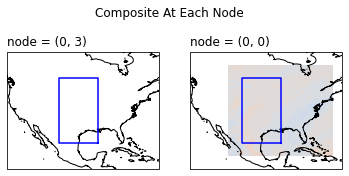

In [34]:
# I don't think this makes sense because the features are just 2 anomalies... if I guess what happens, the four nodes will essentially be 
# Q'>0, V'>0
# Q'>0, V'<0
# Q'<0, V'>0
# Q'<0, V'<0

# and now we can make the maps of each of the composite Q & v anomalies that are associated with each SOM node:
cnorm = mc.TwoSlopeNorm(vmin=-2., vcenter=0, vmax=2)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(6,3), ncols=2, subplot_kw={"projection":ccrs.PlateCarree()})
img = []
for i, k in enumerate(som1NodeAvg):
    # get the right node location:
    ax[i].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    ax[i].set_title(f"node = {k}", loc='left')
    img.append(ax[1].contourf(lons, lats, som1NodeAvg[k], zorder=0, cmap=cmap, norm=cnorm))
    ax[i].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.suptitle("Composite At Each Node")
# fig.colorbar(img)
                       

### second attempt: continued failure
At this point, I realized this approach was failing. Next, I show where the initiation is occurring.

Noting that we see initiation all across the domain, I looked again at Song et al. and found that they only run the SOM analysis on times with initiation within a smaller domain, as shown by the blue box below. 

As you can see, I repeat the analysis with just these events, but with no better results. I also tried making the SOM larger to see if any structure could be identified, but it didn't work. 



In [35]:
lons_da = xr.DataArray(lons.T, dims=("lon","lat"), coords={"lon":lon, "lat":lat})
lats_da = xr.DataArray(lats.T, dims=("lon","lat"), coords={"lon":lon, "lat":lat})
lons_full = lons_da.broadcast_like(mcs_initial_da)
lats_full = lats_da.broadcast_like(mcs_initial_da)

In [36]:
# we might be struggling because everything is collapsing to a single node
# let's take a look at the locations of MCS initiation
# for i in range(1000):
#     if mcs_initial_da[i,:,:].max() > 0:
#         print(f"i = {i} and max = {mcs_initial_da[i,:,:].max()}")

# indices where initiation is marked
nds = np.argwhere(mcs_initial_da.values > 0)


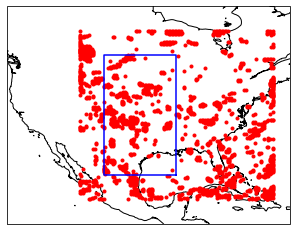

In [40]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
ax.set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
ax.coastlines()
for i in range(nds.shape[0]):
    ax.plot(lons_full[tuple(nds[i,:])], lats_full[tuple(nds[i,:])], transform=ccrs.PlateCarree(), color='red', marker='.')
# draw the new box
# (25°-50°N, 90°-105°W) 
ax.plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')

In [41]:
mcs_small = np.where(((lons_full >= 360-105) & (lons_full <= 360-90)) & ((lats_full >= 15) & (lats_full <= 50)),  mcs_initial_da, 0)
mcs_small.shape

(4712, 149, 129)

In [44]:
# Re-do with only the MCS initiation in the smaller box
# isolate initiation time
mcs_small = xr.DataArray(mcs_small, dims=pdata.dims, coords=pdata.coords)
# simple standardization
v_init2_norm = v_norm[np.where(mcs_small.max(dim=('lat', 'lon'))>0, True, False), :, :]
q_init2_norm = q_norm[np.where(mcs_small.max(dim=('lat', 'lon'))>0, True, False), :, :]

vin1d2 = v_init2_norm.stack(a=("time", "lat","lon"))
qin1d2 = q_init2_norm.stack(a=("time", "lat","lon"))

indata2 = xr.concat([vin1d2,qin1d2], dim='var')


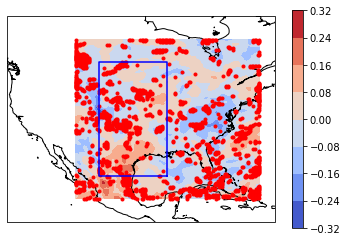

In [46]:
# let's look at the composite Q anomaly 
cnorm = mc.TwoSlopeNorm(vmin=-.3, vcenter=0, vmax=.3)
cmap = "coolwarm"
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})
ax.set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
ax.coastlines()
for i in range(nds.shape[0]):
    ax.plot(lons_full[tuple(nds[i,:])], lats_full[tuple(nds[i,:])], transform=ccrs.PlateCarree(), color='red', marker='.')
img = ax.contourf(lons, lats, q_init2_norm.mean(dim='time').squeeze(), zorder=0,cmap=cmap, norm=cnorm)
# draw teh new box
# (25°-50°N, 90°-105°W) 
ax.plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.colorbar(img)


In [490]:
# Initialization of SOM
som2_shape = (3,3)  # this specifies the 2D output shape of the SOM

# make data such that  
som2 = MiniSom(som2_shape[0], som2_shape[1], indata2.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som2.train_batch(indata2.values, 500, verbose=True)

wm2 = som2.win_map(indata.values)
wm2

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 5.298210951149317e-07


/Users/brianpm/miniconda3/envs/py38/lib/python3.8/site-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


defaultdict(list,
            {(0,
              0): [array([-1.1532135, -1.1422697, -1.0451666, ..., -0.932113 , -0.8688959,
                     -0.7672951], dtype=float32)],
             (2,
              0): [array([-4.0463915 , -3.5402324 , -2.9307706 , ...,  0.08413672,
                      0.05850613,  0.03662164], dtype=float32)]})

### A different approach

One of the confusing things at this point was that I could not understand how Song et al. combine different variables. No application of SOM that I could find explained how to do this for a large spatial dataset. All implementations of SOM appear to rely in the input being the typical (observations (rows), features (columns)). There is no obvious way to link the q and v as occurring coincidently.

Comparing with many other papers that use SOM, there are not many (any?) examples of combining variables and ending up with spatial patterns of those variables. The typical approach is to use MSLP, put each time slice into a 1-dimensional vector and construct the typical input of (time (rows), space (features)). Examples:
- https://www.intechopen.com/books/applications-of-self-organizing-maps/self-organizing-maps-a-powerful-tool-for-the-atmospheric-sciences
- Cassano et al. :  https://doi.org/10.1002/2015JD024404
- Reusch et al. : https://doi.org/10.1029/2006JD007460
- Bao & Wallace : https://doi.org/10.1175/JAS-D-15-0001.1
- Cassano et al. : 10.3354/cr01274

There's a hint in Wang et al. (https://doi.org/10.1175/WAF-D-19-0025.1) that it might be done just by standarizing all the variables. We return to that in a moment.

In the meantime, I wanted to see if I could get any kind of answer from this data and the minisom package. So I just took the Q field alone, and did what made sense based on all the other papers I was seeing. I take the q fields at the initiation times, and stack the space dimensions into a 1-d vector. I arbitrarily chose a 3x3 SOM and used teh same hyperparameters as before. This trains very fast, and produces values in each node. That means that each spatial pattern is being mapped to nodes of the SOM.

Following examples in the minisom repository, I made some initial plots of the results. 

The maps are meaningful. To make them, I use the `win_map` method to get a dictionary that has all the initiation times associated with each node of the SOM. I just loop through that dict and take the average of all those times, reshape back to latxlon and map them. These are the Q anomalies associated with initiation of precipitation events for each node of the SOM. A few dominant patterns emerge, but they might not be very meaningful, this just shows that the SOM is working. Data are being clustered based on the spatial patterns.

The last plot in this section shows two measures of the error of the SOM fit. I think the lack of a derivative shows the main result, but I'm not yet sure whether the absolute value of the quantization error matters. It is much larger than examples, but it could be related to size of data set. 

In [491]:
# Alternative ... see if we can classify the Q field alone as pattern

# so the "feature vector" is just the spatial pattern of Q anomaly and the "observations" are the times of initiation
qindata = q_init2_norm.stack(z=("lat","lon")) # (time x z) q_init2_norm is same as we want here.
print(f"shape of the qindata is {qindata.shape}")

# Initialization of SOM
som3_shape = (3,3)  # this specifies the 2D output shape of the SOM

# make data such that  
som3 = MiniSom(som3_shape[0], som3_shape[1], qindata.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som3.train_batch(qindata.values, 1000, verbose=True)

wm3 = som3.win_map(qindata.values)

shape of the qindata is (128, 19221)
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 110.64439757091637


In [509]:
# each neuron represents a cluster
winner_coordinates = np.array([som3.winner(x) for x in qindata.values]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som3_shape)
print(cluster_index) # this tells us which neuron/node is the winner for each time used.

[2 2 5 8 6 3 7 7 8 8 4 1 7 6 4 2 2 2 2 3 3 6 8 1 1 3 4 7 0 7 7 5 6 0 4 1 1
 2 2 2 3 3 3 2 3 1 7 7 3 8 0 5 5 5 5 1 8 1 6 0 4 3 5 4 8 0 1 1 1 3 6 6 5 8
 0 4 4 3 1 5 5 5 6 6 6 6 0 0 4 1 1 3 5 5 7 8 2 4 3 6 0 6 4 6 6 3 3 8 5 5 8
 6 6 8 2 1 4 4 5 5 7 7 0 0 0 4 8 6]


In [406]:
tot = 0
for k in wm2:
    n = len(wm2[k])
    tot += n
    print(f"for key = {k}, there are {n} entries")
print(f"Total is {tot}")

# Each entry in wm2[k] is sized by nlat * nlon => it is the Qanomaly for one initiation time.

# To "composite" each node of the SOM, we just average all the entries in wm2(k) and then reshape back to space.
composite_anomaly = {}
for k in wm2:
    tmp = np.mean(np.array(wm2[k]), axis=0)
    tmpxr = xr.DataArray(tmp, dims="z", coords={"z":qindata["z"]})
    composite_anomaly[k] = tmpxr.unstack()

for key = (0, 2), there are 12 entries
for key = (1, 2), there are 17 entries
for key = (2, 2), there are 13 entries
for key = (2, 0), there are 18 entries
for key = (1, 0), there are 16 entries
for key = (2, 1), there are 11 entries
for key = (1, 1), there are 14 entries
for key = (0, 1), there are 15 entries
for key = (0, 0), there are 12 entries
Total is 128


[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:>]


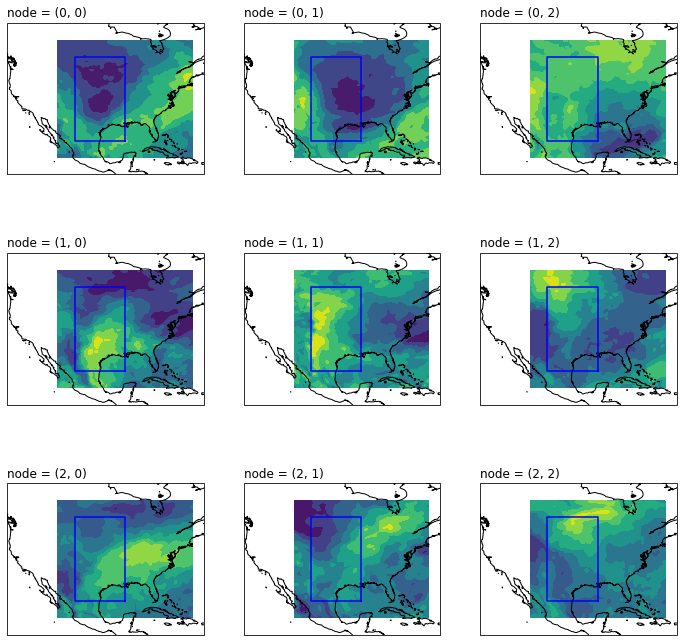

In [407]:
# and now we can make the maps of each of the composite Q anomalies that are associated with each SOM node:

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()})
aa = ax.ravel()
print(aa)
img = []
for i, k in enumerate(composite_anomaly):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    img.append(ax[xx,yy].contourf(lons, lats, composite_anomaly[k], zorder=0))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
# fig.colorbar(img)
                       

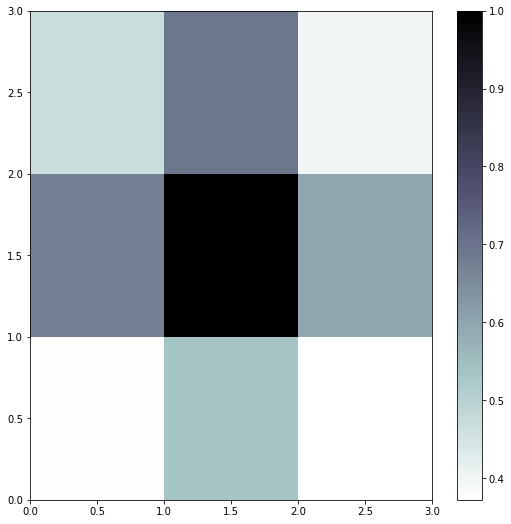

In [510]:
plt.figure(figsize=(9, 9))

plt.pcolor(som3.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

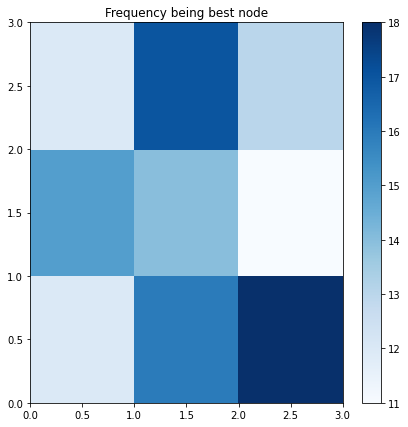

In [511]:
plt.figure(figsize=(7, 7))
frequencies = som3.activation_response(qindata.values)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.title("Frequency being best node")
plt.show()

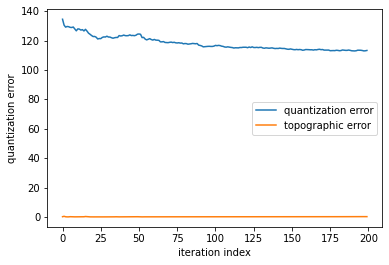

In [512]:
som3Test = MiniSom(som3_shape[0], som3_shape[1], qindata.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 200
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(qindata.values))
    som3Test.update(qindata.values[rand_i], som3Test.winner(qindata.values[rand_i]), i, max_iter)
    q_error.append(som3Test.quantization_error(qindata.values))
    t_error.append(som3Test.topographic_error(qindata.values))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

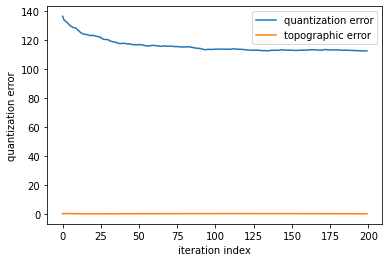

In [515]:
# as a first simple test of the hyperparameters, do this again with
# - a smaller learning rate 0.25 ... smoother blue line, but similar result
# - different neighborhood function (Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle')
#   try bubble w/ learning rate 0.25 ... get warning that sigma >= 1 w/bubble, so set that to 1.
#   => plot looks very similar
som3Test = MiniSom(som3_shape[0], som3_shape[1], qindata.shape[-1], sigma=1, learning_rate=.25,
              neighborhood_function='bubble', random_seed=10)

max_iter = 200
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(qindata.values))
    som3Test.update(qindata.values[rand_i], som3Test.winner(qindata.values[rand_i]), i, max_iter)
    q_error.append(som3Test.quantization_error(qindata.values))
    t_error.append(som3Test.topographic_error(qindata.values))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

### Multi-variable SOM
So given our progress with a single field (i.e., we have something that might be sensible),
we can ask whether the approach used in other studies is to standardize the different anomalies
and treate each as an "observation", so the "feature vector" is the anomaly at each spatial point, 
but for a set of variables that are simply treated equally.

In this next example, we take q just like before and now also do the same with v. Concatenate them together into a single array. The standardization makes them similar in the sense of having zero mean and unit variance. Of course, there is no constraint on higher moments, so I am not confident that this is a good approach. 

As with a single field, this trains quickly even with twice the data. I have not yet explored whether there is any sensitivity to how the training is done. Since we are mixing variables, we might need to make sure that the training occurs on random selections. To be determined. Similarly for the hyperparameters.

So now we are able to look at the composites of each variable in each node. This has a slight complication that we need to know which input rows are which variable. In this simple case, we know the first half are q and second half are v, but we will need a better way to separate if we have many more variables.

**NOTE** that this approach is not correct. It can't really construct physical environments because the patterns of q anomaly and v anomaly are not linked, so they get classified completely separately. See the next section for a more sensible approach where we concatenate the variables into composite feature vectors. 

In [410]:
# so the "feature vector" is just the spatial pattern of Q anomaly and the "observations" are the times of initiation
qindata = q_init_norm.stack(z=("lat","lon")) # (time x z)
vindata = v_init_norm.stack(z=("lat","lon"))
qvindata = np.concatenate((qindata,vindata), axis=0)
print(f"shape of the qvindata is {qvindata.shape}")

# Initialization of SOM
som_shape = (3,3)  # this specifies the 2D output shape of the SOM

# make data such that  
som4 = MiniSom(som_shape[0], som_shape[1], qvindata.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som4.train_batch(qvindata, 1000, verbose=True)

wm4 = som4.win_map(qvindata)

shape of the qvindata is (256, 19221)
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 120.90066948668543


In [411]:
# repeat our analysis from the q-only approach
tot = 0
for k in wm4:
    n = len(wm4[k])
    tot += n
    print(f"for key = {k}, there are {n} entries")
print(f"Total is {tot}")

# Each entry in wm4[k] is sized by nlat * nlon => it is the [Q,v]anomaly for one initiation time.

# To "composite" each node of the SOM, 
# we just average all the entries in wm2(k) and then reshape back to space,
# with the ADDED COMPLICATION that we need to separate Q, V into two different averages
composite_anomaly = {}
for k in wm4:
    tmp = np.mean(np.array(wm4[k]), axis=0)
    tmpxr = xr.DataArray(tmp, dims="z", coords={"z":qindata["z"]})
    composite_anomaly[k] = tmpxr.unstack()

for key = (0, 2), there are 16 entries
for key = (0, 1), there are 33 entries
for key = (1, 0), there are 36 entries
for key = (2, 2), there are 17 entries
for key = (1, 2), there are 25 entries
for key = (0, 0), there are 33 entries
for key = (2, 1), there are 48 entries
for key = (1, 1), there are 29 entries
for key = (2, 0), there are 19 entries
Total is 256


In [412]:
print(qvindata.shape)
# q is first half
qwins = [] # the winning node for q input
for i in range(qvindata.shape[0]//2):
    qwins.append(som4.winner(qvindata[i,:]))
print(qwins)

vwins = [] # the winning node for q input
for i in range(qvindata.shape[0]//2, qvindata.shape[0]):
#     print(f"look at i = {i}")
    vwins.append(som4.winner(qvindata[i,:]))
print(vwins)




(256, 19221)
[(0, 2), (0, 2), (0, 1), (1, 0), (2, 2), (1, 2), (1, 0), (1, 0), (2, 2), (0, 0), (0, 0), (0, 1), (1, 0), (2, 1), (2, 2), (0, 2), (0, 2), (0, 2), (0, 2), (2, 1), (2, 1), (1, 0), (2, 2), (2, 1), (1, 1), (1, 2), (0, 0), (1, 0), (2, 1), (1, 2), (1, 2), (0, 0), (1, 0), (2, 1), (1, 2), (1, 1), (1, 1), (0, 2), (0, 2), (0, 2), (1, 2), (2, 1), (0, 2), (0, 2), (1, 2), (2, 1), (1, 0), (1, 0), (2, 1), (0, 0), (2, 0), (1, 1), (0, 0), (0, 0), (0, 1), (1, 1), (2, 2), (1, 1), (2, 1), (2, 1), (0, 1), (1, 2), (0, 1), (2, 2), (0, 0), (2, 1), (1, 1), (1, 1), (1, 1), (0, 1), (2, 0), (2, 0), (2, 2), (2, 2), (2, 1), (0, 1), (0, 1), (2, 1), (1, 1), (0, 1), (0, 1), (2, 2), (2, 1), (2, 1), (1, 0), (1, 0), (2, 1), (2, 1), (0, 1), (1, 1), (1, 1), (2, 1), (0, 1), (0, 1), (1, 2), (0, 0), (0, 2), (1, 2), (1, 2), (1, 0), (2, 2), (1, 0), (0, 0), (1, 0), (2, 1), (2, 1), (2, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (2, 2), (0, 0), (0, 2), (1, 1), (0, 2), (0, 0), (2, 2), (0, 0), (1, 0), (1, 0), (2, 1), (2

In [426]:
# Construct composites by averaging Q, v in each node
# also keep track of the number
qNodeComposite = {}
qNodeWins = {}
vNodeComposite = {}
vNodeWins = {}
for s in set(qwins):
    atmp = qvindata[0:qvindata.shape[0]//2,:][[k == s for k in qwins],:]
    qNodeWins[s] = atmp.shape[0]
    tmp = np.mean(atmp, axis=0)
    tmpxr = xr.DataArray(tmp, dims="z", coords={"z":qindata["z"]})
    qNodeComposite[s] = tmpxr.unstack()
for s in set(vwins):
    atmp = qvindata[qvindata.shape[0]//2:,:][[k == s for k in vwins],:]
    vNodeWins[s] = atmp.shape[0]
    tmp = np.mean(atmp, axis=0)
    tmpxr = xr.DataArray(tmp, dims="z", coords={"z":qindata["z"]})
    vNodeComposite[s] = tmpxr.unstack()

[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:>]


Text(0.5, 0.98, 'Q Composite At Each Node')

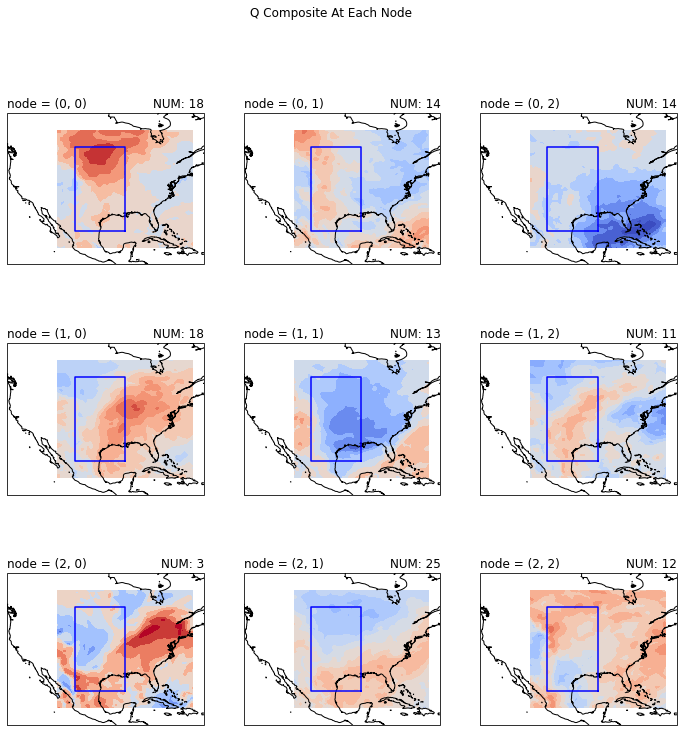

In [427]:
# and now we can make the maps of each of the composite Q & v anomalies that are associated with each SOM node:
cnorm = mc.TwoSlopeNorm(vmin=-2., vcenter=0, vmax=2)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()})
aa = ax.ravel()
print(aa)
img = []
for i, k in enumerate(qNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {qNodeWins[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, qNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.suptitle("Q Composite At Each Node")
# fig.colorbar(img)
                       

[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>
 <GeoAxesSubplot:>]


Text(0.5, 0.98, 'V Composite At Each Node')

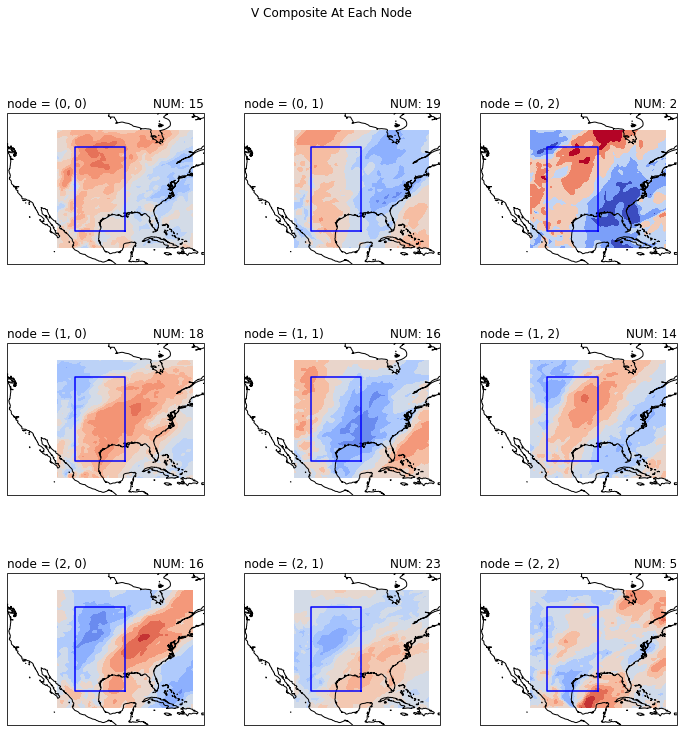

In [429]:
cnorm = mc.TwoSlopeNorm(vmin=-2., vcenter=0, vmax=2)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()})
aa = ax.ravel()
print(aa)
img = []
for i, k in enumerate(vNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {vNodeWins[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, vNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.suptitle("V Composite At Each Node")
# fig.colorbar(img)
                       

## SOM Analysis, Part II

The way Song et al. perform the analysis is by making long feature vectors of the variables. This is actually similar to how \cite{Chattopadhyay:2008} do it, too. 

To make it clear, the data that is used to "train" the SOM is in the standard (observations, features) format. For our case, each "observation" is a time when MCS initiation within our specified region occurs. Our "feature vector" is constructed by taking the full spatial array of the variables to be used. In this toy example we just have two variables, v and q. So the each feature vector will be ($2 \times nlat \times nlon$). 

In [132]:
# scaler defined above 

# v_norm = scaler(v)
# q_norm = scaler(q)

v_init2_norm = v_norm[np.where(mcs_small.max(dim=('lat', 'lon'))>0, True, False), :, :]
q_init2_norm = q_norm[np.where(mcs_small.max(dim=('lat', 'lon'))>0, True, False), :, :]

vin1d2 = v_init2_norm.stack(z=("lat","lon"))
qin1d2 = q_init2_norm.stack(z=("lat","lon"))

qvindata = xr.concat([vin1d2,qin1d2], dim='z')

# print(f"Shape of vin1d2 = {vin1d2.shape}, shape of the qvindata is {qvindata.shape}")

# Initialization of SOM
som_shape = (3,3)  # this specifies the 2D output shape of the SOM

# make data such that  
som5 = MiniSom(som_shape[0], som_shape[1], qvindata.shape[-1], sigma=1, learning_rate=.5,
              neighborhood_function='triangle', random_seed=10)

som5.train_batch(qvindata.values, 1000, verbose=True)

wm5 = som5.win_map(qvindata.values)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 163.6157786481465


In [133]:
# wm5 provides the data for each node when it is the "winner" 
# wm5[node_i] is a list of arrays
# wm5[node_i][j] has size (2 * nlat * nlon)

# Construct composites by averaging Q, v in each node
qNodeComposite = {}
vNodeComposite = {}
winCount = {}

nvars = 2
nlatlon = len(lat)*len(lon)
for node in wm5:
    atmp = np.array(wm5[node])
#     print(f"node = {node}, shape = {atmp.shape}")
    qNodeComposite[node] = xr.DataArray(np.mean(atmp[:, 0:nlatlon], axis=0), dims="z", coords={"z":vin1d2['z']}).unstack()
    vNodeComposite[node] = xr.DataArray(np.mean(atmp[:,nlatlon:], axis=0), dims="z", coords={"z":vin1d2['z']}).unstack()
    winCount[node] = atmp.shape[0]

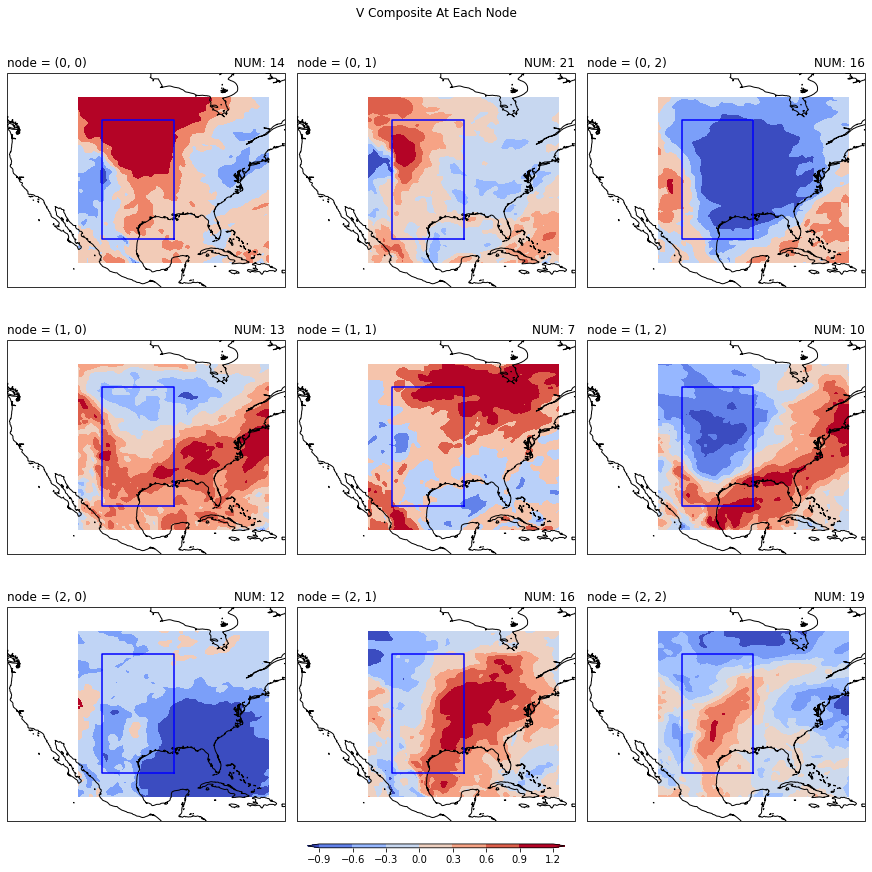

In [134]:
cnorm = mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
img = []
for i, k in enumerate(vNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {winCount[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, vNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm, extend='both'))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.suptitle("V Composite At Each Node")
fig.colorbar(img[-1], ax=ax, shrink=0.3, orientation='horizontal');

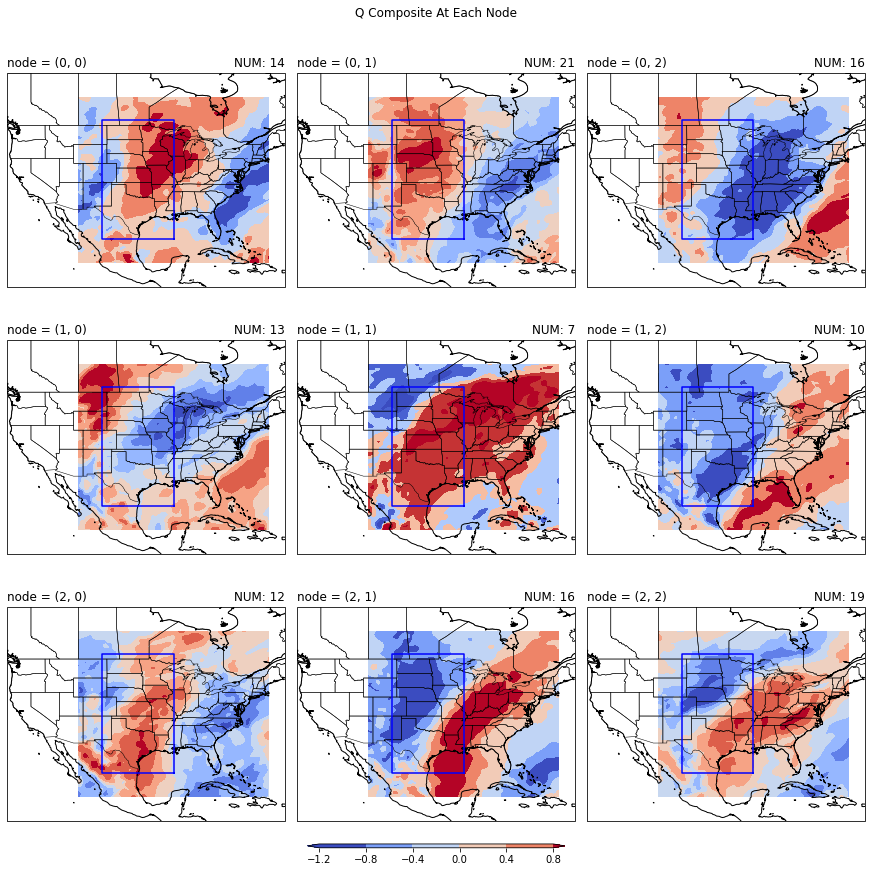

In [138]:
cnorm = mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
img = []
for i, k in enumerate(vNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {winCount[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, qNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm, extend='both'))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
    
[a.add_feature(cfeature.STATES, zorder=1, linewidth=.5, edgecolor='k') for a in aa]

fig.suptitle("Q Composite At Each Node")
fig.colorbar(img[-1], ax=ax, shrink=0.3, orientation='horizontal');